<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2  (Problem 2) - Character Generator Model (Individual)</h2><h3>AY2022/23 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages
import itertools
import random
import sys
import re
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu, sentence_bleu
%matplotlib inline

## Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [2]:
## Open and read the Harry_Potter_Book1.txt file ##

# text = open("/content/drive/My Drive/DL/Harry_Potter_Book1.txt", 'rb').read().decode(encoding='utf-8').lower()
text = open("Harry_Potter_Book1.txt", 'rb').read().decode(encoding='utf-8').lower()

In [3]:
## Check the total number of characters in the original text ##

print("Total number of characters in text file : ", len(text)) 

Total number of characters in text file :  474429


### 1.2 Data Processing


In [4]:
text = text.split("\n")
for line in text:
    if line == "":
        text.remove(line)
for line in text:
    if line[:6] == "page |":
        text.remove(line)
text = "".join(text)

In [5]:
# Remove useless characters
unnecessary_chars = ['-', "|", "/", "[", "]", "\n", "\r", "\\", "■", "•", "(", ")", "&", "@", "*", "#", "—", ";", ":"]


# using replace() to remove bad_chars
for i in unnecessary_chars :
    text = text.replace(i, ' ')
text = re.sub(' +', ' ', text)

# printing resultant number of characters
print('Number of characters in text file :', len(text))

Number of characters in text file : 434300


In [6]:
## Identify a list of unique characters and punctuations in the clean text ##

chars = sorted(list(set(text)))

print('Number of unique characters :', len(chars))
print(chars)

Number of unique characters : 47
[' ', '!', '"', "'", ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '‘', '’', '“', '”']


In [7]:
## Prepare data into training text and labels (X & y) using the "sliding window" method ##

# Length of extracted character sequences (window size)
maxlen = 60

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))
print('sentences[0]: ',sentences[0])
print('next_chars[0]: ',next_chars[0])
print('\n')
print('sentences[1]: ',sentences[1])
print('next_chars[1]: ',next_chars[1])

# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)


Number of sequences: 144747
sentences[0]:   the boy who lived mr. and mrs. dursley, of number four, pri
next_chars[0]:  v


sentences[1]:  e boy who lived mr. and mrs. dursley, of number four, privet
next_chars[1]:   


In [8]:
# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('len(X): ',len(X))
print('X[0]: ',X[0])
print('len(y): ',len(y))
print('y[0]: ',y[0])

Vectorization...
len(X):  144747
X[0]:  [[ True False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
len(y):  144747
y[0]:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False]


In [9]:
print("Total number of characters: ", len(text))
print("X :", len(X))
print(X.shape)
print("y :", len(y))
print(y.shape)

Total number of characters:  434300
X : 144747
(144747, 60, 47)
y : 144747
(144747, 47)


In [10]:
print(len(X[0]))
print(X[0])
print(len(X[0][0]))
print(X[0][0])

60
[[ True False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
47
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]


In [11]:
# Functions

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas) #return to the selected "next character"

#supporting function
def _split_into_words(sentences):
  """Splits multiple sentences into words and flattens the result"""
  return list(itertools.chain(*[_.split(" ") for _ in sentences]))

#supporting function
def _get_word_ngrams(n, sentences):
  """Calculates word n-grams for multiple sentences.
  """
  assert len(sentences) > 0
  assert n > 0

  words = _split_into_words(sentences)
  return _get_ngrams(n, words)

#supporting function
def _get_ngrams(n, text):
  """Calcualtes n-grams.
  Args:
    n: which n-grams to calculate
    text: An array of tokens
  Returns:
    A set of n-grams
  """
  ngram_set = set()
  text_length = len(text)
  max_index_ngram_start = text_length - n
  for i in range(max_index_ngram_start + 1):
    ngram_set.add(tuple(text[i:i + n]))
  return ngram_set

def rouge_n(reference_sentences, evaluated_sentences, n=2):
  """
  Computes ROUGE-N of two text collections of sentences.
  Source: http://research.microsoft.com/en-us/um/people/cyl/download/
  papers/rouge-working-note-v1.3.1.pdf
  Args:
    evaluated_sentences: The sentences that have been picked by the summarizer
    reference_sentences: The sentences from the referene set
    n: Size of ngram.  Defaults to 2.
  Returns:
    recall rouge score(float)
  Raises:
    ValueError: raises exception if a param has len <= 0
  """
  if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
    raise ValueError("Collections must contain at least 1 sentence.")

  evaluated_ngrams = _get_word_ngrams(n, evaluated_sentences)
  reference_ngrams = _get_word_ngrams(n, reference_sentences)
  reference_count = len(reference_ngrams)
  evaluated_count = len(evaluated_ngrams)

  # Gets the overlapping ngrams between evaluated and reference
  overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
  overlapping_count = len(overlapping_ngrams)

  # Handle edge case. This isn't mathematically correct, but it's good enough
  if evaluated_count == 0:
    precision = 0.0
  else:
    precision = overlapping_count / evaluated_count

  if reference_count == 0:
    recall = 0.0
  else:
    recall = overlapping_count / reference_count

  f1_score = 2.0 * ((precision * recall) / (precision + recall + 1e-8))

  #just returning recall count in rouge, useful for our purpose
  return recall


def graphs(history):
 acc = history.history['acc']
 val_acc = history.history['val_acc']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 epochs = range(len(acc))
 plt.plot(epochs, acc, 'bo', label='Training acc')
 plt.plot(epochs, val_acc, 'b', label='Validation acc')
 plt.title('Training and validation accuracy')
 plt.legend()
 plt.figure()
 plt.plot(epochs, loss, 'bo', label='Training loss')
 plt.plot(epochs, val_loss, 'b', label='Validation loss')
 plt.title('Training and validation loss')
 plt.legend()
 plt.show()
 return


def compile_fit(model, optimizer, loss, metrics, callback, batch_size, epochs, X, y):
 model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
 history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                     validation_split=0.2, callbacks=callback, verbose=1)

 return history

def gen_text(model):
  start_index = random.randint(0, len(text) - maxlen - 1)
  generated_text_initial = text[start_index: start_index + maxlen]
  print('--- Generating with seed: "' + generated_text_initial + '"')
  for temperature in [0.2, 0.5, 1.0, 1.2]:
   generated_text = generated_text_initial
   rogue_future_text = text[start_index+maxlen: start_index+maxlen + 401]
   rogue_gen_text = ""
   print('------ temperature:', temperature)
   sys.stdout.write(generated_text)

   # We generate 400 characters
   for i in range(400):
       sampled = np.zeros((1, maxlen, len(chars)))
       for t, char in enumerate(generated_text):
           sampled[0, t, char_indices[char]] = 1.

       preds = model.predict(sampled, verbose=0)[0]  # to get the softmax output
       next_index = sample(preds, temperature)
       next_char = chars[next_index]

       generated_text += next_char
       generated_text = generated_text[1:]

       rogue_gen_text += next_char

       sys.stdout.write(next_char)
       sys.stdout.flush()
   print("\nRogue_Score")
   print(rouge_n(rogue_future_text, rogue_gen_text))
   print()
  return

## Step 2 – Develop Character Generator Model

Epoch 1/100
453/453 [==============================] - 8s 13ms/step - loss: 2.3136 - acc: 0.3353 - val_loss: 1.9558 - val_acc: 0.4123
Epoch 2/100
453/453 [==============================] - 6s 13ms/step - loss: 1.8155 - acc: 0.4542 - val_loss: 1.7251 - val_acc: 0.4816
Epoch 3/100
453/453 [==============================] - 5s 11ms/step - loss: 1.6557 - acc: 0.4974 - val_loss: 1.6516 - val_acc: 0.4999
Epoch 4/100
453/453 [==============================] - 5s 11ms/step - loss: 1.5623 - acc: 0.5205 - val_loss: 1.6026 - val_acc: 0.5155
Epoch 5/100
453/453 [==============================] - 5s 11ms/step - loss: 1.4973 - acc: 0.5395 - val_loss: 1.5694 - val_acc: 0.5223
Epoch 6/100
453/453 [==============================] - 5s 11ms/step - loss: 1.4491 - acc: 0.5536 - val_loss: 1.5386 - val_acc: 0.5346
Epoch 7/100
453/453 [==============================] - 5s 11ms/step - loss: 1.4107 - acc: 0.5635 - val_loss: 1.5154 - val_acc: 0.5446
Epoch 8/100
453/453 [==============================] - 5s 11ms

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


the stool the floor. harry stood and the boy and students of them and started to the gryffindor.” “what was still the next endeared and the stool the stood the cloak to the stool the corridors towering at the first sit on the floor. harry stood the floor. harry stood the first time and the boy and harry stood and the boy and the stool and the stool the door.” “i trying to the first them it wa
Rogue_Score
0.3756906077348066

------ temperature: 0.5
retched to the breaking point with anxiety about harry. “i’m not a pulling her arry’s wail tell the other and his famous asleep the robe she tried to have a little trying to the third to disappeared. he had started to the startied the rest.” harry’s bunning to partended to look the on the clanped. “he was something it. he couldn’t have been toward the cartrong,” hermione said harry. “it it to think yet it was too known broomsticks shop. the first my the st
Rogue_Score
0.5580110497237569

------ temperature: 1.0
retched to the breaking point w

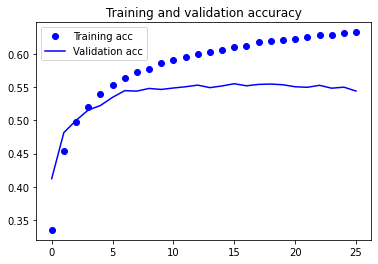

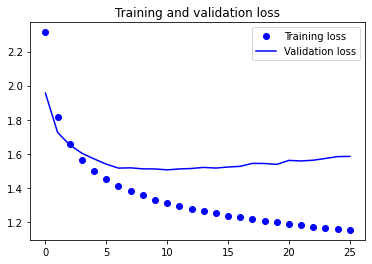

In [ ]:
# GRU (Selected)

model = Sequential()
model.add(GRU(64, input_shape=(maxlen, len(chars)), return_sequences=True))
model.add(GRU(64))
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

gen_text(model)

graphs(history)

Epoch 1/100
453/453 [==============================] - 18s 27ms/step - loss: 2.4613 - acc: 0.2970 - val_loss: 2.1129 - val_acc: 0.3835
Epoch 2/100
453/453 [==============================] - 10s 22ms/step - loss: 1.9509 - acc: 0.4231 - val_loss: 1.8371 - val_acc: 0.4569
Epoch 3/100
453/453 [==============================] - 10s 22ms/step - loss: 1.7521 - acc: 0.4736 - val_loss: 1.7119 - val_acc: 0.4904
Epoch 4/100
453/453 [==============================] - 10s 22ms/step - loss: 1.6346 - acc: 0.5057 - val_loss: 1.6311 - val_acc: 0.5081
Epoch 5/100
453/453 [==============================] - 10s 22ms/step - loss: 1.5522 - acc: 0.5291 - val_loss: 1.5968 - val_acc: 0.5212
Epoch 6/100
453/453 [==============================] - 10s 22ms/step - loss: 1.4923 - acc: 0.5432 - val_loss: 1.5762 - val_acc: 0.5263
Epoch 7/100
453/453 [==============================] - 10s 22ms/step - loss: 1.4469 - acc: 0.5566 - val_loss: 1.5401 - val_acc: 0.5388
Epoch 8/100
453/453 [==============================] - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


the hall. “we couldn’t stand the storm and slasses and the stands around the stairs around the hall. “that’s about the compartment was so warry. he was so poining at the stairs of the dursleys’ stoom as all. “i was a school and the corridors are a chostmes, and they were a stands around the staring around the starion sixtled as though he was a size to see the stands of the school. he was some
Rogue_Score
0.42696629213483145

------ temperature: 0.5
ey twins and lee jordan were tickling the tentacles of a gian to say of the holdor and spell. “i’ve got to the hall still down a stairs, i helping madam ranging, he’d been a dived on its appier and his black in the spech and snake out of the door and sight all over his corner firsell liked it air and the house the stopped out a pack of her family at it. it was so never dark and hermione.” “i have a sole, the door and scrain was a really courd about the poi
Rogue_Score
0.5730337078651685

------ temperature: 1.0
ey twins and lee jordan were t

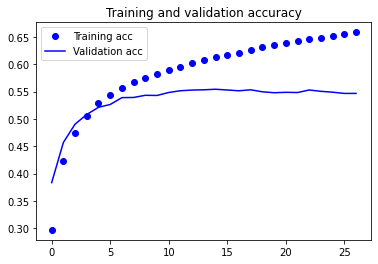

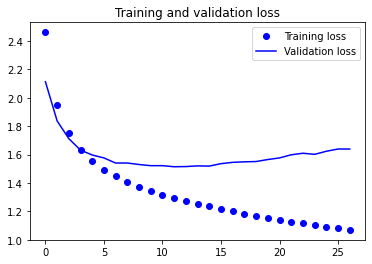

In [ ]:
# Bidirectional LSTM
model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(64)))
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

gen_text(model)

graphs(history)

Epoch 1/100
453/453 [==============================] - 9s 14ms/step - loss: 2.6763 - acc: 0.2490 - val_loss: 2.3377 - val_acc: 0.3088
Epoch 2/100
453/453 [==============================] - 6s 12ms/step - loss: 2.1966 - acc: 0.3553 - val_loss: 2.0983 - val_acc: 0.3927
Epoch 3/100
453/453 [==============================] - 6s 13ms/step - loss: 2.0302 - acc: 0.4029 - val_loss: 1.9783 - val_acc: 0.4223
Epoch 4/100
453/453 [==============================] - 6s 13ms/step - loss: 1.9275 - acc: 0.4297 - val_loss: 1.9076 - val_acc: 0.4366
Epoch 5/100
453/453 [==============================] - 6s 13ms/step - loss: 1.8479 - acc: 0.4496 - val_loss: 1.8321 - val_acc: 0.4568
Epoch 6/100
453/453 [==============================] - 6s 13ms/step - loss: 1.7811 - acc: 0.4668 - val_loss: 1.7757 - val_acc: 0.4714
Epoch 7/100
453/453 [==============================] - 6s 13ms/step - loss: 1.7256 - acc: 0.4820 - val_loss: 1.7345 - val_acc: 0.4869
Epoch 8/100
453/453 [==============================] - 6s 12ms

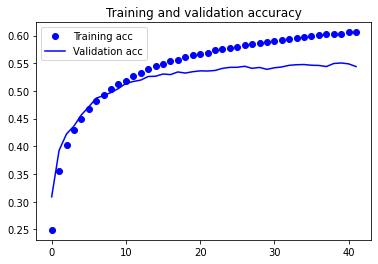

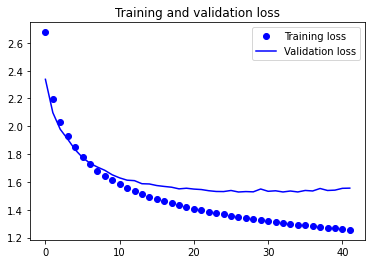

--- Generating with seed: "ges, a poker, a teapot, several chipped mugs, and a bottle o"
------ temperature: 0.2
ges, a poker, a teapot, several chipped mugs, and a bottle of the

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


 train stare was fatching a lot of the stands and then have the start the start and sat in the stone on the start the start the students to stop the stands of the dark a sight made the game the done a sight made the start the dark and the corridor had started to the hat and started to the weasleys and started to the crabbe and harry had started to the dark she was a very weasley and harry and
Rogue_Score
0.4124293785310734

------ temperature: 0.5
ges, a poker, a teapot, several chipped mugs, and a bottle of the first thing the first.” “malfoy in the stone him and harry never done a right around the train in a shant of the hand at quidditch the shop a cup the way to where yem harry face the handing the take that first had staiched his in a suppering the dark back to the boat before and a starvisel wand at the hand all the dursleys had a siend harry had are sname was facted his wand the crass for the
Rogue_Score
0.5423728813559322

------ temperature: 1.0
ges, a poker, a teapot, several

In [ ]:
# LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(maxlen, len(chars)), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

gen_text(model)

Bidirectional LSTM

Epoch 1/100
453/453 [==============================] - 24s 36ms/step - loss: 2.5394 - acc: 0.2830 - val_loss: 2.1967 - val_acc: 0.3525
Epoch 2/100
453/453 [==============================] - 14s 31ms/step - loss: 2.0506 - acc: 0.3957 - val_loss: 1.9284 - val_acc: 0.4329
Epoch 3/100
453/453 [==============================] - 14s 31ms/step - loss: 1.8492 - acc: 0.4490 - val_loss: 1.7949 - val_acc: 0.4653
Epoch 4/100
453/453 [==============================] - 15s 33ms/step - loss: 1.7209 - acc: 0.4833 - val_loss: 1.6921 - val_acc: 0.4919
Epoch 5/100
453/453 [==============================] - 15s 32ms/step - loss: 1.6288 - acc: 0.5073 - val_loss: 1.6379 - val_acc: 0.5066
Epoch 6/100
453/453 [==============================] - 14s 32ms/step - loss: 1.5583 - acc: 0.5254 - val_loss: 1.5965 - val_acc: 0.5189
Epoch 7/100
453/453 [==============================] - 14s 31ms/step - loss: 1.5007 - acc: 0.5409 - val_loss: 1.5714 - val_acc: 0.5247
Epoch 8/100
453/453 [==============================] - 

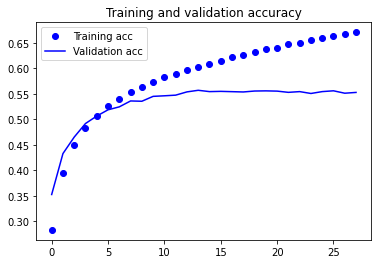

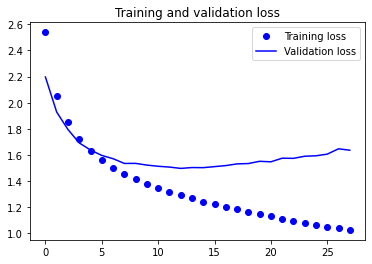

--- Generating with seed: "d told him so far was unbelievable, harry couldn’t help trus"
------ temperature: 0.2
d told him so far was unbelievable, harry couldn’t help trusters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


 of the cart, and they were seemed to be the cart of the couldered of the stood of the stood of the way and started to snape was so harry was the stories, they were supposed to hagrid to start their table. “i hearn head on the dursleys’ got an ambols to see his mind of his life. “i hearn anything in the way of top the street to the street to hagrid to have got to have to know the street the wi
Rogue_Score
0.525

------ temperature: 0.5
d told him so far was unbelievable, harry couldn’t help trustion, wood house in tight here you think he had a lot of madam time to come to see his nick they’ll still harry had to know the dursleys and found came still stone platform and then were of the shun an agrived diffediin’ it. “so that were so harry’s not streaked to the door and do white he’d street to give to the hall, take bullin’t something to him back still stunder with the window normiced to g
Rogue_Score
0.625

------ temperature: 1.0
d told him so far was unbelievable, harry couldn’t help 

In [ ]:
# +1 RNN Layer

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(LSTM(64)))
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 22s 38ms/step - loss: 2.4044 - acc: 0.3153 - val_loss: 2.0160 - val_acc: 0.4106
Epoch 2/100
453/453 [==============================] - 16s 35ms/step - loss: 1.8400 - acc: 0.4546 - val_loss: 1.7252 - val_acc: 0.4838
Epoch 3/100
453/453 [==============================] - 15s 34ms/step - loss: 1.6222 - acc: 0.5102 - val_loss: 1.6054 - val_acc: 0.5156
Epoch 4/100
453/453 [==============================] - 15s 34ms/step - loss: 1.4995 - acc: 0.5407 - val_loss: 1.5453 - val_acc: 0.5312
Epoch 5/100
453/453 [==============================] - 16s 35ms/step - loss: 1.4037 - acc: 0.5685 - val_loss: 1.5089 - val_acc: 0.5454
Epoch 6/100
453/453 [==============================] - 16s 34ms/step - loss: 1.3377 - acc: 0.5849 - val_loss: 1.4989 - val_acc: 0.5555
Epoch 7/100
453/453 [==============================] - 16s 35ms/step - loss: 1.2772 - acc: 0.5996 - val_loss: 1.4872 - val_acc: 0.5584
Epoch 8/100
453/453 [==============================] - 

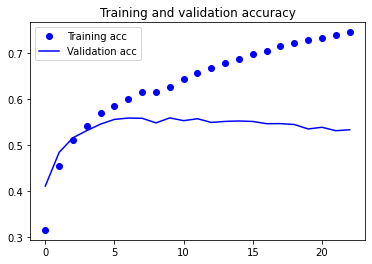

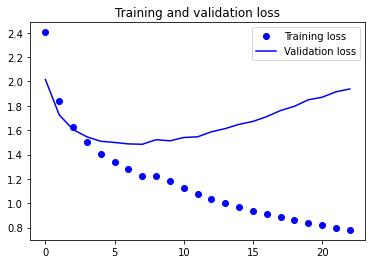

--- Generating with seed: "nd fang. they walked for nearly half an hour, deeper and dee"
------ temperature: 0.2
nd fang. they walked for nearly half an hour, deeper and deep a big he was trying to 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


force him, but he wasn’t sure they were sunkn’ mising flushts, and the lever was seen a letter than he seemed to be secan the counts, froght the shop, and hermione was christmers and scrabbles of the snape, but he saw stick, both of the floor. and the gryffindor hum, and they were sure things of a pass of shock about a sizing of the snape of the snape, and hermione gringin
Rogue_Score
0.6274509803921569

------ temperature: 0.5
nd fang. they walked for nearly half an hour, deeper and deep about the was seen on the hat stepped at the dursleys. “well, i d if me taking from what he was about his face next his arm?” “i mean, dumbledore was coming from hermione granger, them and the left side and then, eville vernon?” “all dumbledore of all team,” ron leaved to the cood fast, they spent slipped with his face by the school. he was so parting harry and hermione seemed to becoute him, ha
Rogue_Score
0.6078431372549019

------ temperature: 1.0
nd fang. they walked for nearly half an hour, deepe

In [ ]:
# 128 RNN Nodes

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(128)))
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 47s 92ms/step - loss: 2.3355 - acc: 0.3291 - val_loss: 1.9357 - val_acc: 0.4349
Epoch 2/100
453/453 [==============================] - 39s 87ms/step - loss: 1.7423 - acc: 0.4769 - val_loss: 1.6379 - val_acc: 0.5053
Epoch 3/100
453/453 [==============================] - 40s 88ms/step - loss: 1.5208 - acc: 0.5343 - val_loss: 1.5362 - val_acc: 0.5351
Epoch 4/100
453/453 [==============================] - 40s 88ms/step - loss: 1.3846 - acc: 0.5712 - val_loss: 1.4721 - val_acc: 0.5536
Epoch 5/100
453/453 [==============================] - 40s 88ms/step - loss: 1.2865 - acc: 0.5987 - val_loss: 1.4597 - val_acc: 0.5634
Epoch 6/100
453/453 [==============================] - 40s 88ms/step - loss: 1.1981 - acc: 0.6229 - val_loss: 1.4589 - val_acc: 0.5646
Epoch 7/100
453/453 [==============================] - 40s 88ms/step - loss: 1.1182 - acc: 0.6450 - val_loss: 1.4637 - val_acc: 0.5689
Epoch 8/100
453/453 [==============================] - 

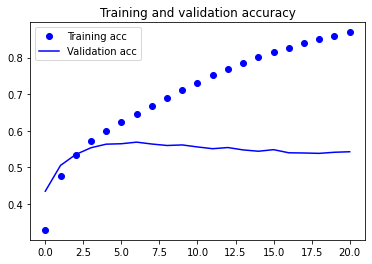

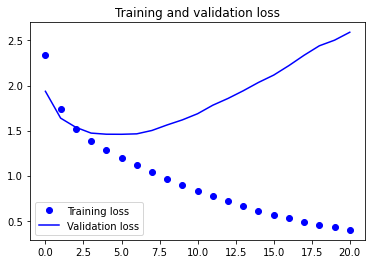

--- Generating with seed: "and feet. he bowed as they walked inside. now they were faci"
------ temperature: 0.2
and feet. he bowed as they walked inside. now they were facilf an

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


d work, too. it took to the dursleys had woken up to face he was still ashow it, hanned a bit. an owls. it was almost gliffed to learn the corridor as they had shouddled a sixtuch were for the first time in his eremind and a floor and floor who came all over the paise. “and do you wouldn’t be saying for gurss. it were you, timed you go to do an’ james for? as they had already cauldron?” “do y
Rogue_Score
0.61875

------ temperature: 0.5
and feet. he bowed as they walked inside. now they were facilf and wold waved a few weed off, good up to the floor, toward the hat fell on your house for the first time in the leaky could and dangerously. “dumbledore, was there’s sorcerer’s stone, it was almost as as the first brother as he could tell him out witched and funge to a pointing for and then were to think he stared aunt ne to flew how to believe it up, said dumbledore, sir. and land the cloak f
Rogue_Score
0.65625

------ temperature: 1.0
and feet. he bowed as they walked inside. now they we

In [ ]:
# 256 RNN Nodes

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(256)))
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 22s 37ms/step - loss: 2.4217 - acc: 0.3079 - val_loss: 2.0652 - val_acc: 0.4012
Epoch 2/100
453/453 [==============================] - 16s 35ms/step - loss: 1.8926 - acc: 0.4393 - val_loss: 1.7773 - val_acc: 0.4754
Epoch 3/100
453/453 [==============================] - 17s 37ms/step - loss: 1.6720 - acc: 0.4952 - val_loss: 1.6507 - val_acc: 0.5085
Epoch 4/100
453/453 [==============================] - 16s 34ms/step - loss: 1.5502 - acc: 0.5293 - val_loss: 1.5665 - val_acc: 0.5322
Epoch 5/100
453/453 [==============================] - 17s 37ms/step - loss: 1.4528 - acc: 0.5549 - val_loss: 1.5271 - val_acc: 0.5441
Epoch 6/100
453/453 [==============================] - 16s 34ms/step - loss: 1.3818 - acc: 0.5739 - val_loss: 1.5069 - val_acc: 0.5483
Epoch 7/100
453/453 [==============================] - 16s 35ms/step - loss: 1.3257 - acc: 0.5886 - val_loss: 1.5044 - val_acc: 0.5479
Epoch 8/100
453/453 [==============================] - 

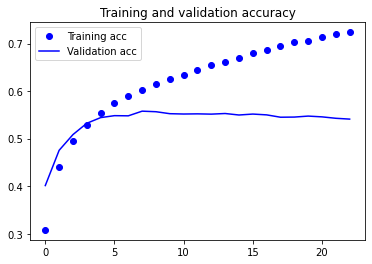

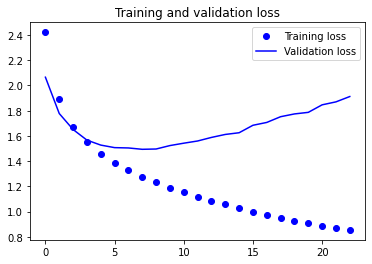

--- Generating with seed: "peering at harry, “is this can this be ?” the leaky cauldron"
------ temperature: 0.2
peering at harry, “is this can this be ?” the leaky cauldron over th

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


em. he sat a large bothout another two black of spells and the great sittening a do wait at the last week and seemed to be as they clept to the common and hermione walked anything to be himself and harry had spept a long flamor in the stool them all the cloak of the great hall as he slint back out a long. “it of the stool and pelt and barked to be a head of the common shopid after the cloa
Rogue_Score
0.5287356321839081

------ temperature: 0.5
peering at harry, “is this can this be ?” the leaky cauldron and the other table and screamed from the glasses over his ginging to take his feet, someone to the common well. “the chast of the girle of the common as she was talling open the door, something to do. it had a small had the foother and saw the shelv to do. “that i call heaver the loud famous going on, do it as he was going to tell her for an even hagrid anything into take the sige of the cloak o
Rogue_Score
0.5057471264367817

------ temperature: 1.0
peering at harry, “is this can thi

In [ ]:
# +1 Dense

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(128)))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 23s 39ms/step - loss: 2.4667 - acc: 0.2934 - val_loss: 2.1670 - val_acc: 0.3571
Epoch 2/100
453/453 [==============================] - 16s 35ms/step - loss: 1.9547 - acc: 0.4231 - val_loss: 1.8260 - val_acc: 0.4598
Epoch 3/100
453/453 [==============================] - 15s 34ms/step - loss: 1.7314 - acc: 0.4822 - val_loss: 1.7217 - val_acc: 0.4889
Epoch 4/100
453/453 [==============================] - 16s 35ms/step - loss: 1.5989 - acc: 0.5168 - val_loss: 1.6198 - val_acc: 0.5188
Epoch 5/100
453/453 [==============================] - 15s 34ms/step - loss: 1.5041 - acc: 0.5417 - val_loss: 1.5566 - val_acc: 0.5325
Epoch 6/100
453/453 [==============================] - 16s 34ms/step - loss: 1.4329 - acc: 0.5618 - val_loss: 1.5339 - val_acc: 0.5463
Epoch 7/100
453/453 [==============================] - 17s 37ms/step - loss: 1.3763 - acc: 0.5755 - val_loss: 1.5272 - val_acc: 0.5444
Epoch 8/100
453/453 [==============================] - 

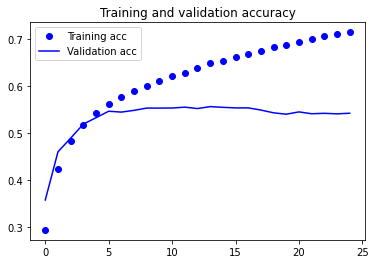

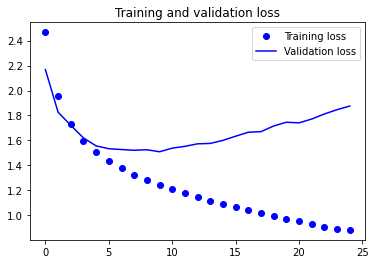

--- Generating with seed: " off course, harry holding on for dear life. “foul!” screame"
------ temperature: 0.2
 off course, harry holding on for dear life. “foul!” screamed to 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


have the banks has grasper the mirror where he had said for the migangly be fore will for hogwarts was so points inside the foul boom and said. “it’s he was almost back and harry had gream at the stairs. he was starting to bed. he was so points as he could have to stand the since the happs and the common and the man was silently stare and says you kitch before you know you want happened at th
Rogue_Score
0.5680473372781065

------ temperature: 0.5
 off course, harry holding on for dear life. “foul!” screamed all the back for a to mester being at the mightains. a hang in a leaky one stands was still for a will he change’s stands was it was anoter and pointyout and pointy candles, hagrid dimpor of great hall something malf in the potters and a magic be in mr. dursley must have the weasley was silence faced points into the nata stairs and said a soin weasley still cloak as they wanted the time traie in
Rogue_Score
0.5443786982248521

------ temperature: 1.0
 off course, harry holding on f

In [ ]:
# +2 Dense Layers

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(128)))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 22s 38ms/step - loss: 2.3820 - acc: 0.3178 - val_loss: 1.9612 - val_acc: 0.4284
Epoch 2/100
453/453 [==============================] - 16s 35ms/step - loss: 1.7837 - acc: 0.4658 - val_loss: 1.6751 - val_acc: 0.4966
Epoch 3/100
453/453 [==============================] - 17s 37ms/step - loss: 1.5706 - acc: 0.5188 - val_loss: 1.5575 - val_acc: 0.5253
Epoch 4/100
453/453 [==============================] - 15s 34ms/step - loss: 1.4482 - acc: 0.5539 - val_loss: 1.5071 - val_acc: 0.5403
Epoch 5/100
453/453 [==============================] - 16s 34ms/step - loss: 1.3613 - acc: 0.5767 - val_loss: 1.4802 - val_acc: 0.5494
Epoch 6/100
453/453 [==============================] - 15s 34ms/step - loss: 1.2881 - acc: 0.5959 - val_loss: 1.4640 - val_acc: 0.5541
Epoch 7/100
453/453 [==============================] - 16s 35ms/step - loss: 1.2431 - acc: 0.6065 - val_loss: 1.4827 - val_acc: 0.5486
Epoch 8/100
453/453 [==============================] - 

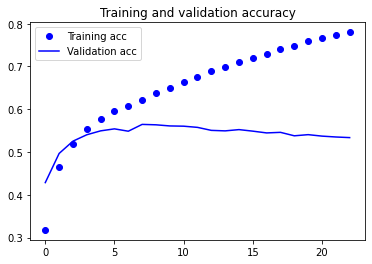

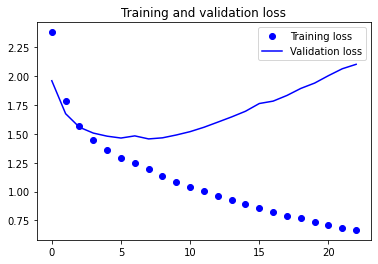

--- Generating with seed: ". ... i bet,” he added, voicing for the first time something"
------ temperature: 0.2
. ... i bet,” he added, voicing for the first time something he was creeks and

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


 he was surrow scared pober a different was a suppoting to the school. “we out a large packages, dudley to me, and you’re seen a bit professor mcgonagall weam,” he said and harry seemed to the first years, there were to say the wet harry. he looked so much about the shop. he was would be was a suiftion. he was surrow was he had to fack fluttering stuffs, a mother and fast asleep.
Rogue_Score
0.5903614457831325

------ temperature: 0.5
. ... i bet,” he added, voicing for the first time something that weren’t must have come six, it were up to the parfelsy wizard’s head of the table. the dursleys’ work out of his hee ter sight as the epcept the shop, and hermione was her quickly from sure her eyes flying. “i’ve already got a moment.” harry pushed on to him, who came before he couldn’t try, where they were all the rest of the chayswounded pulling to run if ther stools were about a hat on th
Rogue_Score
0.6927710843373494

------ temperature: 1.0
. ... i bet,” he added, voicing for the firs

In [ ]:
# Dense 128 Nodes

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(128)))
model.add(Dense(128, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 22s 38ms/step - loss: 2.3265 - acc: 0.3272 - val_loss: 1.9007 - val_acc: 0.4359
Epoch 2/100
453/453 [==============================] - 16s 35ms/step - loss: 1.7511 - acc: 0.4701 - val_loss: 1.6493 - val_acc: 0.4942
Epoch 3/100
453/453 [==============================] - 16s 34ms/step - loss: 1.5511 - acc: 0.5217 - val_loss: 1.5420 - val_acc: 0.5289
Epoch 4/100
453/453 [==============================] - 17s 37ms/step - loss: 1.4312 - acc: 0.5528 - val_loss: 1.4948 - val_acc: 0.5395
Epoch 5/100
453/453 [==============================] - 16s 34ms/step - loss: 1.3459 - acc: 0.5787 - val_loss: 1.4588 - val_acc: 0.5580
Epoch 6/100
453/453 [==============================] - 15s 34ms/step - loss: 1.2762 - acc: 0.5960 - val_loss: 1.4436 - val_acc: 0.5598
Epoch 7/100
453/453 [==============================] - 17s 37ms/step - loss: 1.2162 - acc: 0.6099 - val_loss: 1.4498 - val_acc: 0.5635
Epoch 8/100
453/453 [==============================] - 

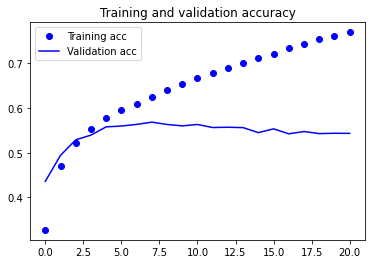

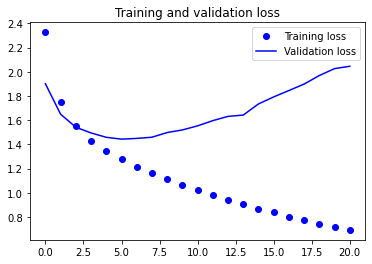

--- Generating with seed: "oad, who looked as though he’d been making another bid for f"
------ temperature: 0.2
oad, who looked as though he’d been making another bid for for him?” “it 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


had been causant ron, who was talking the troll’s relacked the grounds. “i’d have a bitten old more portrait that weren’t here than it had been trembled in the compartment swarve, harry had seen that harry shoped the cloak harry couldn’t see it.” harry had seen that harry suddenly really and harry had to start something the great lide and fleet as dudley had a siggle. “it’s that muggl
Rogue_Score
0.550561797752809

------ temperature: 0.5
oad, who looked as though he’d been making another bid for for himself in the cloak of the stool tower the shops the stool than as he stood there, and the back of the stool of the look of the shop the compared and the was so flint of the end of the house hair. the end of the shops.” “what i don’t be an enomes. that’s not slid of the stone!” he asked ron, staring into the wall, the empty had make a second and harry had a long paite back of the stool shop at
Rogue_Score
0.5168539325842697

------ temperature: 1.0
oad, who looked as though he’d been maki

In [ ]:
# Dense 256 Nodes

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(128)))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 22s 37ms/step - loss: 2.2053 - acc: 0.3598 - val_loss: 1.8120 - val_acc: 0.4554
Epoch 2/100
453/453 [==============================] - 16s 34ms/step - loss: 1.6545 - acc: 0.4950 - val_loss: 1.5786 - val_acc: 0.5203
Epoch 3/100
453/453 [==============================] - 17s 38ms/step - loss: 1.4813 - acc: 0.5420 - val_loss: 1.5108 - val_acc: 0.5404
Epoch 4/100
453/453 [==============================] - 16s 35ms/step - loss: 1.3781 - acc: 0.5697 - val_loss: 1.4686 - val_acc: 0.5535
Epoch 5/100
453/453 [==============================] - 15s 34ms/step - loss: 1.3053 - acc: 0.5888 - val_loss: 1.4618 - val_acc: 0.5580
Epoch 6/100
453/453 [==============================] - 17s 37ms/step - loss: 1.2445 - acc: 0.6046 - val_loss: 1.4604 - val_acc: 0.5634
Epoch 7/100
453/453 [==============================] - 15s 34ms/step - loss: 1.1952 - acc: 0.6179 - val_loss: 1.4696 - val_acc: 0.5648
Epoch 8/100
453/453 [==============================] - 

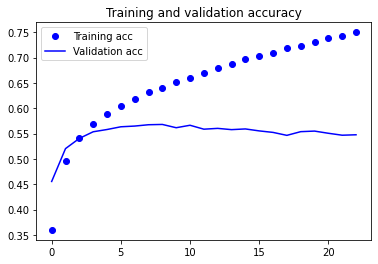

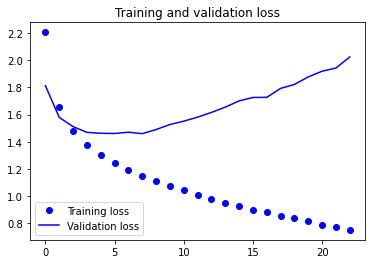

--- Generating with seed: "t be on the team. ...” “so i suppose you think that’s a rewa"
------ temperature: 0.2
t be on the team. ...” “so i suppose you think that’s a rewand the

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


m stop ball. the weasleys favorite stood and slot of the door to mout.” “it’s heart forget it, there were quidditch ron wouldn’t be potion the stairs in a second the hair’s barried at the was still stood and slot of the chairday on her wand as starting at the portrait of the troll’s had started the staircase platers to the mirror. there was a bit and was stand at a staircas white close book 
Rogue_Score
0.5414364640883977

------ temperature: 0.5
t be on the team. ...” “so i suppose you think that’s a rewand them she’d be some calbed this storm and then the floor, the dursleys seemed the other two statle of the moter of accie of smothering toward the room. “it’s harry?” “i can that happensed to dumbledore stared, “what had had had arrived the invisible. he was the ball at ron. “stay was the reat them not don’t you are humbred him and the portrait of the step of bed, but he broken interous, petunia.
Rogue_Score
0.5911602209944752

------ temperature: 1.0
t be on the team. ...” “so i sup

In [ ]:
# Learning Rate = 0.005

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(128)))
model.add(Dense(128, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 23s 40ms/step - loss: 2.6177 - acc: 0.2631 - val_loss: 2.3086 - val_acc: 0.3246
Epoch 2/100
453/453 [==============================] - 16s 35ms/step - loss: 2.1206 - acc: 0.3749 - val_loss: 1.9903 - val_acc: 0.4112
Epoch 3/100
453/453 [==============================] - 16s 34ms/step - loss: 1.8866 - acc: 0.4361 - val_loss: 1.8121 - val_acc: 0.4584
Epoch 4/100
453/453 [==============================] - 17s 37ms/step - loss: 1.7401 - acc: 0.4759 - val_loss: 1.7037 - val_acc: 0.4900
Epoch 5/100
453/453 [==============================] - 15s 34ms/step - loss: 1.6308 - acc: 0.5045 - val_loss: 1.6384 - val_acc: 0.5013
Epoch 6/100
453/453 [==============================] - 17s 37ms/step - loss: 1.5503 - acc: 0.5268 - val_loss: 1.5862 - val_acc: 0.5176
Epoch 7/100
453/453 [==============================] - 16s 35ms/step - loss: 1.4832 - acc: 0.5445 - val_loss: 1.5515 - val_acc: 0.5297
Epoch 8/100
453/453 [==============================] - 

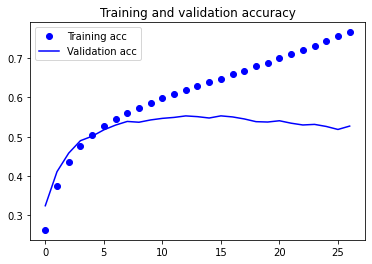

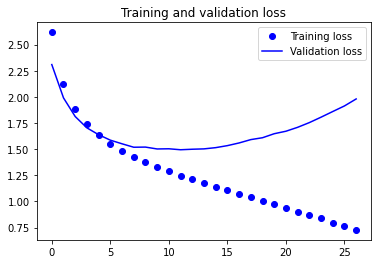

--- Generating with seed: "side. he hoped the roof wasn’t going to fall in, although he"
------ temperature: 0.2
side. he hoped the roof wasn’t going to fall in, although he’d had 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


anyway, why have to know it after eyes from he caughter on the train of them all anything things in the dursleys and the school of colles, all through her head the train for look and should as the spake. he was street. “draw you what i’ve got toa reach it was a sink of of these is. they had to be a bit of the twins the score taking the dursleys wouldn’t be a lot of a pulled by whene he stoo
Rogue_Score
0.5935483870967742

------ temperature: 0.5
side. he hoped the roof wasn’t going to fall in, although he’d hallew they’re weasled to beay so preace was she pointed at the snake looking from and weither all all. he was still the boy must dragon it. it was the point at the gryffindor half in the classroom and had been in the train and with ron are reeling him on the excone. “that’s the train rather wandered the boy the reper then professor flite said hold a bit of as they had alreaded a britemal amble
Rogue_Score
0.5548387096774193

------ temperature: 1.0
side. he hoped the roof wasn’t go

In [ ]:
# Learning Rate = 0.001

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(128)))
model.add(Dense(128, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 24s 40ms/step - loss: 2.1226 - acc: 0.3801 - val_loss: 1.8264 - val_acc: 0.4497
Epoch 2/100
453/453 [==============================] - 17s 37ms/step - loss: 1.7374 - acc: 0.4750 - val_loss: 1.6726 - val_acc: 0.4945
Epoch 3/100
453/453 [==============================] - 17s 37ms/step - loss: 1.6120 - acc: 0.5090 - val_loss: 1.6026 - val_acc: 0.5151
Epoch 4/100
453/453 [==============================] - 17s 37ms/step - loss: 1.5268 - acc: 0.5311 - val_loss: 1.5614 - val_acc: 0.5299
Epoch 5/100
453/453 [==============================] - 17s 37ms/step - loss: 1.4654 - acc: 0.5467 - val_loss: 1.5350 - val_acc: 0.5359
Epoch 6/100
453/453 [==============================] - 17s 37ms/step - loss: 1.4107 - acc: 0.5620 - val_loss: 1.5080 - val_acc: 0.5466
Epoch 7/100
453/453 [==============================] - 17s 37ms/step - loss: 1.3714 - acc: 0.5723 - val_loss: 1.4995 - val_acc: 0.5491
Epoch 8/100
453/453 [==============================] - 

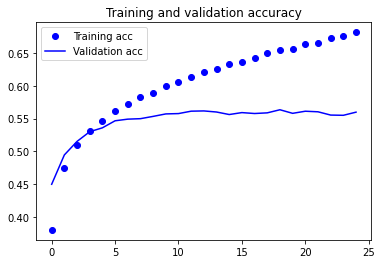

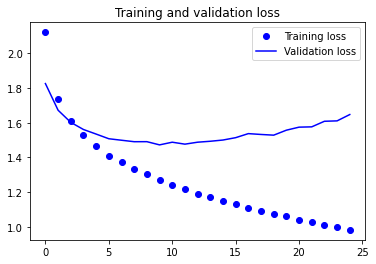

--- Generating with seed: "er eyes, and sat down. a moment’s pause “hufflepuff!” shoute"
------ temperature: 0.2
er eyes, and sat down. a moment’s pause “hufflepuff!” shouted the witch started to the mirror and they were a bit of the street and made a bit of the station to

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


 the gryffindor break with his wand the wall, stood off to the minutes to the way about to the corner the station to the wand to the students and from his binoto with the hair stood a sharpl of the twins. “i’m have this,” he said, “if i’d be a stain of them seeker that had been to see in the library
Rogue_Score
0.535031847133758

------ temperature: 0.5
er eyes, and sat down. a moment’s pause “hufflepuff!” shouted the grass back and the mountant. “i want to do and i’d be get to the door that happens. they might be harry was some who mound a break of bounding out for the gryffindor houses and big of will be to move the life short and bried and see they street at the start trieve had been a large eyed and she was colde more the classroom windon endrart the fire to harry because his life. “what’s the wand to
Rogue_Score
0.5414012738853503

------ temperature: 1.0
er eyes, and sat down. a moment’s pause “hufflepuff!” shouted the house, and cried to matte. “what who you show it i’d lose a k

In [ ]:
# Layer Normalization

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.LayerNormalization())
model.add(tf.keras.layers.Bidirectional(LSTM(128)))
model.add(tf.keras.layers.LayerNormalization())
model.add(Dense(128, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 24s 41ms/step - loss: 2.4769 - acc: 0.2929 - val_loss: 2.0009 - val_acc: 0.4029
Epoch 2/100
453/453 [==============================] - 17s 37ms/step - loss: 2.0847 - acc: 0.3848 - val_loss: 1.7931 - val_acc: 0.4603
Epoch 3/100
453/453 [==============================] - 17s 37ms/step - loss: 1.9465 - acc: 0.4206 - val_loss: 1.6874 - val_acc: 0.4866
Epoch 4/100
453/453 [==============================] - 17s 36ms/step - loss: 1.8677 - acc: 0.4396 - val_loss: 1.6271 - val_acc: 0.5016
Epoch 5/100
453/453 [==============================] - 17s 37ms/step - loss: 1.8137 - acc: 0.4534 - val_loss: 1.5833 - val_acc: 0.5132
Epoch 6/100
453/453 [==============================] - 17s 37ms/step - loss: 1.7793 - acc: 0.4627 - val_loss: 1.5556 - val_acc: 0.5190
Epoch 7/100
453/453 [==============================] - 17s 37ms/step - loss: 1.7508 - acc: 0.4697 - val_loss: 1.5474 - val_acc: 0.5239
Epoch 8/100
453/453 [==============================] - 

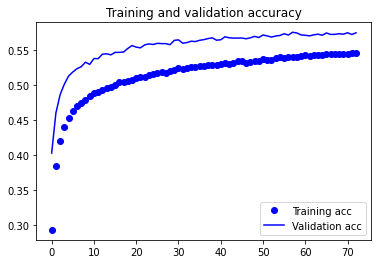

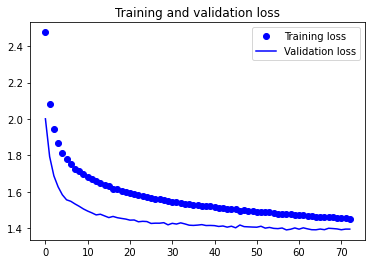

--- Generating with seed: "cauldron. he was looking very peculiar in a large purple tur"
------ temperature: 0.2
cauldron. he was looking very peculiar in a large purple turning 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


to see the course of the stair of strange for the stair of strange and the school and the other feather of the stair of the corner and the stare of the stair and the corner and the stair of the stair of the ground, and the stare and say his books and the stair of the stair of the stair and the stare of the stair of the stair and the first between and the stare something to the ground and sat 
Rogue_Score
0.3987730061349693

------ temperature: 0.5
cauldron. he was looking very peculiar in a large purple turning to the third and through the three of the weasleys. “the time of malfoy been the snound before change were all that the rest of his side for the twisting from the house of the snowl gave the ground. he was an room and harry and harry had been up a lot as the rown from the swapped. harry sat the train and spends for the ground. the harry to hear, ron and harry noticed the rest of the street of
Rogue_Score
0.5521472392638037

------ temperature: 1.0
cauldron. he was looking very p

In [ ]:
# Dropout 0.3

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.3, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.3)))
model.add(Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 24s 42ms/step - loss: 2.4589 - acc: 0.2971 - val_loss: 1.9890 - val_acc: 0.4155
Epoch 2/100
453/453 [==============================] - 17s 37ms/step - loss: 2.0102 - acc: 0.4024 - val_loss: 1.7560 - val_acc: 0.4703
Epoch 3/100
453/453 [==============================] - 18s 39ms/step - loss: 1.8510 - acc: 0.4451 - val_loss: 1.6575 - val_acc: 0.4917
Epoch 4/100
453/453 [==============================] - 18s 39ms/step - loss: 1.7683 - acc: 0.4647 - val_loss: 1.6003 - val_acc: 0.5088
Epoch 5/100
453/453 [==============================] - 17s 38ms/step - loss: 1.7138 - acc: 0.4791 - val_loss: 1.5559 - val_acc: 0.5201
Epoch 6/100
453/453 [==============================] - 17s 37ms/step - loss: 1.6743 - acc: 0.4882 - val_loss: 1.5264 - val_acc: 0.5311
Epoch 7/100
453/453 [==============================] - 17s 37ms/step - loss: 1.6417 - acc: 0.4979 - val_loss: 1.5121 - val_acc: 0.5367
Epoch 8/100
453/453 [==============================] - 

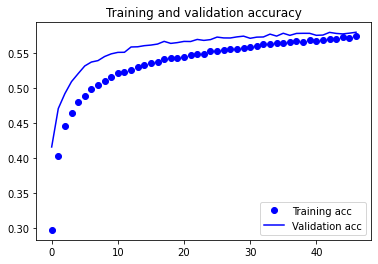

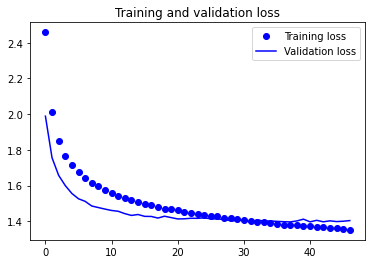

--- Generating with seed: "sheet. when he had found his voice again, harry said, “and t"
------ temperature: 0.2
sheet. when he had found his voice again, harry said, “and the ha

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


t had a something in the stairs and hermione was a silence he sat and harry and harry was still what he was still had an each of the stand and he sat and hermione started to the silver and the stairs and hermione was started at him and a pointed out of the ground and the stairs and the hat and hermione was a potter was a pointed and saw the street and said the stairs and hermione was started 
Rogue_Score
0.3956043956043956

------ temperature: 0.5
sheet. when he had found his voice again, harry said, “and the drindor, she was street the hat of the fire the boat, harry leent off in the time the fire in the silence explain with the ball was a large really stood of him and going to sir he sat something the corridor looking at the speet as he said. “it’s going to hear the silver had no doing at him far the house are she said to tell him that he had stopped to the window his feet and ron still could have
Rogue_Score
0.5439560439560439

------ temperature: 1.0
sheet. when he had found his vo

In [ ]:
# Dropout 0.2

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.2, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.2)))
model.add(Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 25s 43ms/step - loss: 2.3305 - acc: 0.3275 - val_loss: 1.8627 - val_acc: 0.4435
Epoch 2/100
453/453 [==============================] - 17s 38ms/step - loss: 1.8260 - acc: 0.4492 - val_loss: 1.6531 - val_acc: 0.4921
Epoch 3/100
453/453 [==============================] - 17s 37ms/step - loss: 1.6735 - acc: 0.4888 - val_loss: 1.5613 - val_acc: 0.5238
Epoch 4/100
453/453 [==============================] - 16s 36ms/step - loss: 1.5891 - acc: 0.5116 - val_loss: 1.5113 - val_acc: 0.5333
Epoch 5/100
453/453 [==============================] - 17s 37ms/step - loss: 1.5322 - acc: 0.5264 - val_loss: 1.4830 - val_acc: 0.5423
Epoch 6/100
453/453 [==============================] - 17s 37ms/step - loss: 1.4906 - acc: 0.5378 - val_loss: 1.4638 - val_acc: 0.5496
Epoch 7/100
453/453 [==============================] - 17s 37ms/step - loss: 1.4565 - acc: 0.5459 - val_loss: 1.4460 - val_acc: 0.5562
Epoch 8/100
453/453 [==============================] - 

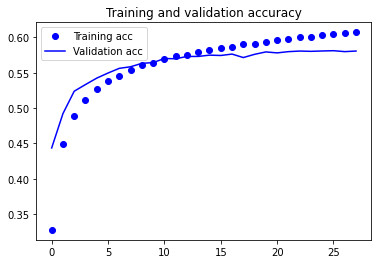

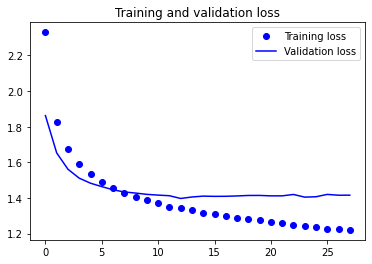

--- Generating with seed: "like yer dad, but yeh’ve got yer mom’s eyes.” uncle vernon m"
------ temperature: 0.2
like yer dad, but yeh’ve got yer mom’s eyes.” uncle vernon made his boy 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


was staring at the floor. “i know how the since and the street that the stool of the stairs and the street to the library was the street was the stool to start and the stool of the corner and staring at the top of the thousand and they were to say and the stool and that he was still as they were a story of the room. he was strangers and harry told the house they had a suppose to the fi
Rogue_Score
0.43373493975903615

------ temperature: 0.5
like yer dad, but yeh’ve got yer mom’s eyes.” uncle vernon move at harry stood a great story and with saying a large stool. hagrid streamed to the rock didn’t show his reports in the thousand and the scabbers at the night could they’d found a bit of harry’s to do to be tricks and was they could hear the compartment to the drop second from him filch trool, to the gryffindor had a lot down as harry was madam sight had been come as the mirror of stood was a s
Rogue_Score
0.5060240963855421

------ temperature: 1.0
like yer dad, but yeh’ve got yer mom’

In [ ]:
# Dropout 0.1 (Selected)

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.1, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.1)))
model.add(Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 24s 42ms/step - loss: 2.4824 - acc: 0.3144 - val_loss: 2.0131 - val_acc: 0.4130
Epoch 2/100
453/453 [==============================] - 17s 37ms/step - loss: 1.9874 - acc: 0.4183 - val_loss: 1.8191 - val_acc: 0.4668
Epoch 3/100
453/453 [==============================] - 18s 39ms/step - loss: 1.8616 - acc: 0.4521 - val_loss: 1.7530 - val_acc: 0.4837
Epoch 4/100
453/453 [==============================] - 17s 37ms/step - loss: 1.7925 - acc: 0.4698 - val_loss: 1.7010 - val_acc: 0.4966
Epoch 5/100
453/453 [==============================] - 17s 37ms/step - loss: 1.7458 - acc: 0.4823 - val_loss: 1.6661 - val_acc: 0.5117
Epoch 6/100
453/453 [==============================] - 17s 37ms/step - loss: 1.7108 - acc: 0.4909 - val_loss: 1.6388 - val_acc: 0.5156
Epoch 7/100
453/453 [==============================] - 17s 37ms/step - loss: 1.6808 - acc: 0.4982 - val_loss: 1.6297 - val_acc: 0.5211
Epoch 8/100
453/453 [==============================] - 

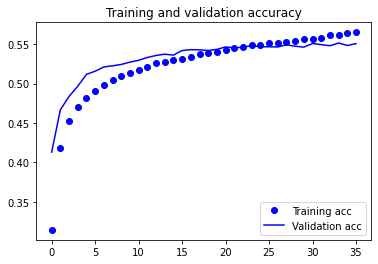

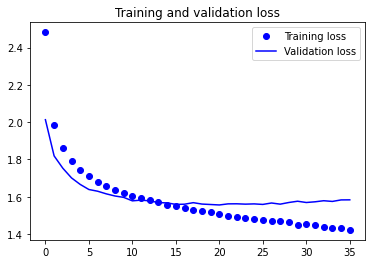

--- Generating with seed: " said nearly headless nick delicately. when everyone had eat"
------ temperature: 0.2
 said nearly headless nick delicately. when everyone had eathing t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


he had hermione stare had seemed to the stairs and a stared to the start the stained at the stared to the stared the started the was started the same and the start feeling the could the gran to see and stared to the same and a bat the boy the started to be the stands the same the started the door and the started the started the started to see the stained at the looked the same and the start 
Rogue_Score
0.3446327683615819

------ temperature: 0.5
 said nearly headless nick delicately. when everyone had eat to do the stop the boy the stands the boy and the defore beard and the was snape in the opened his door do and the grangerous down the could a getting the was a single a boit to dudley’s make to the tree were come had been a masure the steper the lot the speching the latever and a she dudley’s the same the the team over the tair came he could the row a see here done of the sat the seconds the sai
Rogue_Score
0.4632768361581921

------ temperature: 1.0
 said nearly headless nick delic

In [ ]:
# Regularizers = 0.01

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.1, recurrent_regularizer=tf.keras.regularizers.L2(l2=0.01), return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.1, recurrent_regularizer=tf.keras.regularizers.L2(l2=0.01))))
model.add(Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 25s 42ms/step - loss: 2.4429 - acc: 0.3190 - val_loss: 2.0235 - val_acc: 0.4029
Epoch 2/100
453/453 [==============================] - 17s 37ms/step - loss: 1.9930 - acc: 0.4162 - val_loss: 1.8290 - val_acc: 0.4565
Epoch 3/100
453/453 [==============================] - 18s 40ms/step - loss: 1.8669 - acc: 0.4504 - val_loss: 1.7421 - val_acc: 0.4801
Epoch 4/100
453/453 [==============================] - 17s 37ms/step - loss: 1.7960 - acc: 0.4692 - val_loss: 1.7020 - val_acc: 0.4965
Epoch 5/100
453/453 [==============================] - 17s 37ms/step - loss: 1.7506 - acc: 0.4803 - val_loss: 1.6565 - val_acc: 0.5130
Epoch 6/100
453/453 [==============================] - 17s 37ms/step - loss: 1.7125 - acc: 0.4914 - val_loss: 1.6459 - val_acc: 0.5168
Epoch 7/100
453/453 [==============================] - 17s 37ms/step - loss: 1.6836 - acc: 0.4985 - val_loss: 1.6221 - val_acc: 0.5132
Epoch 8/100
453/453 [==============================] - 

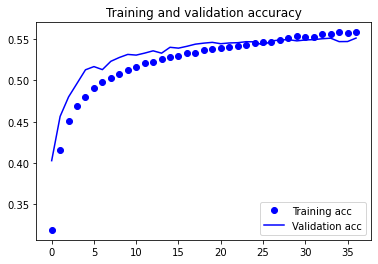

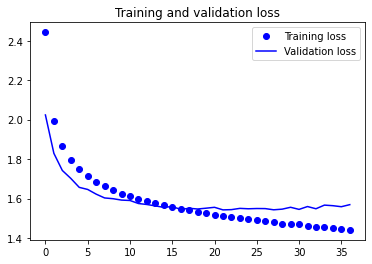

--- Generating with seed: " dursley picked up his briefcase, pecked mrs. dursley on the"
------ temperature: 0.2
 dursley picked up his briefcase, pecked mrs. dursley on the cou

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


ldn’t see the should a start and his he was the start and start the same was started and the start and the start and something the shoulders and the started the should the scabber and the the gray the same and his started for the started of the start a stack and the start to the shop to the shops and his could the stool the start to his stain the stood of the couldn’t start the sort a start an
Rogue_Score
0.3712574850299401

------ temperature: 0.5
 dursley picked up his briefcase, pecked mrs. dursley on the wouldn’t don’t tell around the does. in the cloak to the smell brance of of the more cart the cold the looking the way and caught was all all the seemed to first into signout of it, and quidditch took a long off saw at his the second you have of something her cold the great way for a swidest the started and have flying the didn’t could the same in on the ways and someone to the stool. he was what
Rogue_Score
0.5688622754491018

------ temperature: 1.0
 dursley picked up his briefca

In [ ]:
# Regularizers = 0.007

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.1, recurrent_regularizer=tf.keras.regularizers.L2(l2=0.007), return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.1, recurrent_regularizer=tf.keras.regularizers.L2(l2=0.007))))
model.add(Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)


graphs(history)

gen_text(model)

CONV1D Model



Epoch 1/100
453/453 [==============================] - 14s 7ms/step - loss: 2.2623 - acc: 0.3553 - val_loss: 1.9336 - val_acc: 0.4298
Epoch 2/100
453/453 [==============================] - 3s 6ms/step - loss: 1.7894 - acc: 0.4675 - val_loss: 1.7991 - val_acc: 0.4685
Epoch 3/100
453/453 [==============================] - 4s 9ms/step - loss: 1.6220 - acc: 0.5081 - val_loss: 1.7548 - val_acc: 0.4789
Epoch 4/100
453/453 [==============================] - 5s 10ms/step - loss: 1.5014 - acc: 0.5392 - val_loss: 1.7588 - val_acc: 0.4761
Epoch 5/100
453/453 [==============================] - 4s 8ms/step - loss: 1.4048 - acc: 0.5638 - val_loss: 1.7827 - val_acc: 0.4718
Epoch 6/100
453/453 [==============================] - 3s 7ms/step - loss: 1.3307 - acc: 0.5838 - val_loss: 1.8519 - val_acc: 0.4708
Epoch 7/100
453/453 [==============================] - 3s 6ms/step - loss: 1.2669 - acc: 0.6004 - val_loss: 1.8837 - val_acc: 0.4644
Epoch 8/100
453/453 [==============================] - 3s 6ms/step 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


” said harber. harry said. he started the drorpost on the could a let look to harry’s out to the stop. fere sugh their yeh to say. he was to know was a dir letter they mode a looking to know what had his bean to ore open the storather was moyging him filcolan the snare cat the fatoo she tored a toud the had boak at the rasting by harry, which be platen to still say his back, a would,
Rogue_Score
0.5254237288135594

------ temperature: 0.5
suggested. “ really break your leg,” said ron. “i can’t,” said harry. “them and he had be aute hously shat. “we harry clasereak now he’d feech arow, shouly, beforce on to oh clamily, to scars agay dursley shout it by spped abarry for hay snapped. the gold harry. with hogwarts gold any adought u mrs a start wark your fast a few with him who way of as harry comerharth them,” said harry. “what as and let mr.” harry day and shone his boad an the that to kneath
Rogue_Score
0.5988700564971752

------ temperature: 1.0
suggested. “ really break your leg,” sai

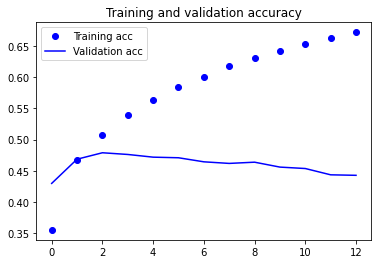

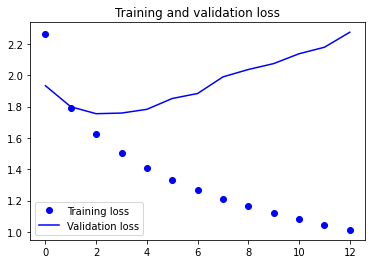

In [ ]:
# Conv1D Baseline

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, input_shape=(maxlen, len(chars)), kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 5s 9ms/step - loss: 2.3081 - acc: 0.3429 - val_loss: 1.9300 - val_acc: 0.4309
Epoch 2/100
453/453 [==============================] - 4s 9ms/step - loss: 1.8024 - acc: 0.4666 - val_loss: 1.7725 - val_acc: 0.4782
Epoch 3/100
453/453 [==============================] - 3s 8ms/step - loss: 1.6422 - acc: 0.5062 - val_loss: 1.7331 - val_acc: 0.4865
Epoch 4/100
453/453 [==============================] - 4s 8ms/step - loss: 1.5382 - acc: 0.5336 - val_loss: 1.7151 - val_acc: 0.4904
Epoch 5/100
453/453 [==============================] - 4s 10ms/step - loss: 1.4570 - acc: 0.5533 - val_loss: 1.7061 - val_acc: 0.4956
Epoch 6/100
453/453 [==============================] - 5s 11ms/step - loss: 1.3902 - acc: 0.5690 - val_loss: 1.7468 - val_acc: 0.4908
Epoch 7/100
453/453 [==============================] - 5s 10ms/step - loss: 1.3318 - acc: 0.5863 - val_loss: 1.7501 - val_acc: 0.4903
Epoch 8/100
453/453 [==============================] - 4s 9ms/step

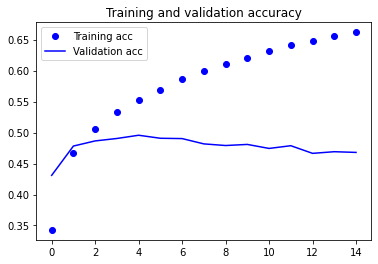

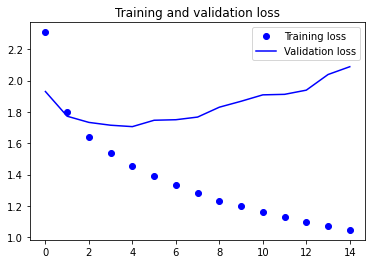

In [ ]:
# +1 Conv1D/Maxpool layer (selected)

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, input_shape=(maxlen, len(chars)), kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

Epoch 1/100
453/453 [==============================] - 5s 10ms/step - loss: 2.3639 - acc: 0.3333 - val_loss: 1.9911 - val_acc: 0.4265
Epoch 2/100
453/453 [==============================] - 4s 9ms/step - loss: 1.8278 - acc: 0.4619 - val_loss: 1.7688 - val_acc: 0.4791
Epoch 3/100
453/453 [==============================] - 5s 11ms/step - loss: 1.6714 - acc: 0.5005 - val_loss: 1.6971 - val_acc: 0.4953
Epoch 4/100
453/453 [==============================] - 5s 11ms/step - loss: 1.5778 - acc: 0.5231 - val_loss: 1.6656 - val_acc: 0.5053
Epoch 5/100
453/453 [==============================] - 4s 10ms/step - loss: 1.5031 - acc: 0.5421 - val_loss: 1.6583 - val_acc: 0.5060
Epoch 6/100
453/453 [==============================] - 4s 9ms/step - loss: 1.4421 - acc: 0.5584 - val_loss: 1.6603 - val_acc: 0.5134
Epoch 7/100
453/453 [==============================] - 4s 10ms/step - loss: 1.3881 - acc: 0.5710 - val_loss: 1.6936 - val_acc: 0.5107
Epoch 8/100
453/453 [==============================] - 4s 9ms/st

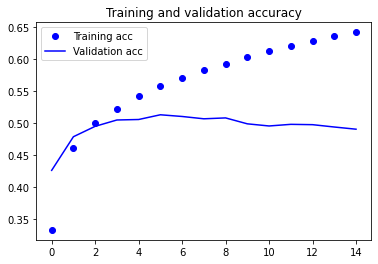

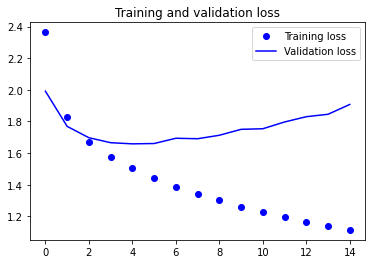

In [ ]:
# +2 Conv1D/Maxpool layer

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, input_shape=(maxlen, len(chars)), kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

Epoch 1/100
453/453 [==============================] - 7s 13ms/step - loss: 2.5104 - acc: 0.2924 - val_loss: 2.0498 - val_acc: 0.4180
Epoch 2/100
453/453 [==============================] - 5s 12ms/step - loss: 1.8607 - acc: 0.4554 - val_loss: 1.7725 - val_acc: 0.4807
Epoch 3/100
453/453 [==============================] - 6s 13ms/step - loss: 1.6631 - acc: 0.5037 - val_loss: 1.6827 - val_acc: 0.4992
Epoch 4/100
453/453 [==============================] - 6s 12ms/step - loss: 1.5357 - acc: 0.5352 - val_loss: 1.6352 - val_acc: 0.5145
Epoch 5/100
453/453 [==============================] - 6s 12ms/step - loss: 1.4336 - acc: 0.5609 - val_loss: 1.6486 - val_acc: 0.5117
Epoch 6/100
453/453 [==============================] - 6s 12ms/step - loss: 1.3428 - acc: 0.5842 - val_loss: 1.6777 - val_acc: 0.5072
Epoch 7/100
453/453 [==============================] - 5s 12ms/step - loss: 1.2578 - acc: 0.6073 - val_loss: 1.7446 - val_acc: 0.5025
Epoch 8/100
453/453 [==============================] - 6s 13ms

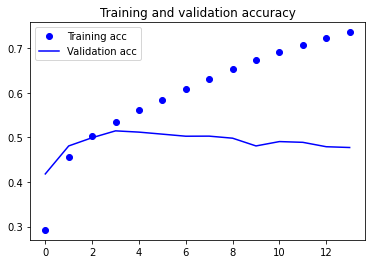

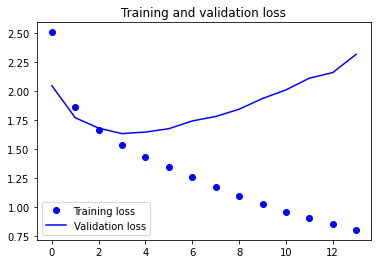

In [ ]:
# 128 Nodes (Selected)

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=128, input_shape=(maxlen, len(chars)), kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

Epoch 1/100
453/453 [==============================] - 13s 27ms/step - loss: 2.2623 - acc: 0.3570 - val_loss: 1.8624 - val_acc: 0.4599
Epoch 2/100
453/453 [==============================] - 12s 26ms/step - loss: 1.7278 - acc: 0.4851 - val_loss: 1.6962 - val_acc: 0.4964
Epoch 3/100
453/453 [==============================] - 12s 26ms/step - loss: 1.5534 - acc: 0.5292 - val_loss: 1.6580 - val_acc: 0.5083
Epoch 4/100
453/453 [==============================] - 12s 26ms/step - loss: 1.4177 - acc: 0.5640 - val_loss: 1.6639 - val_acc: 0.5080
Epoch 5/100
453/453 [==============================] - 11s 25ms/step - loss: 1.2903 - acc: 0.5968 - val_loss: 1.7240 - val_acc: 0.5047
Epoch 6/100
453/453 [==============================] - 11s 25ms/step - loss: 1.1733 - acc: 0.6293 - val_loss: 1.7565 - val_acc: 0.4994
Epoch 7/100
453/453 [==============================] - 11s 25ms/step - loss: 1.0607 - acc: 0.6600 - val_loss: 1.8446 - val_acc: 0.4958
Epoch 8/100
453/453 [==============================] - 

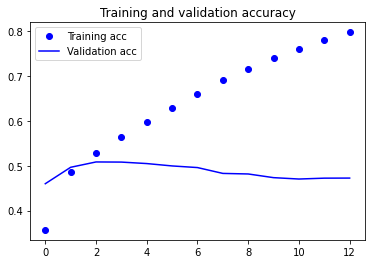

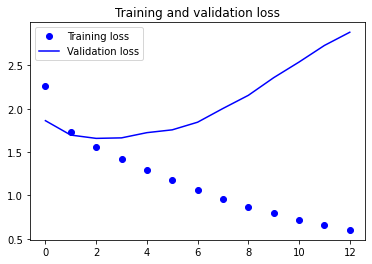

In [ ]:
# 256 nodes

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=256, input_shape=(maxlen, len(chars)), kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

Epoch 1/100
453/453 [==============================] - 8s 17ms/step - loss: 2.5368 - acc: 0.2868 - val_loss: 2.0545 - val_acc: 0.4017
Epoch 2/100
453/453 [==============================] - 6s 13ms/step - loss: 1.8771 - acc: 0.4488 - val_loss: 1.7945 - val_acc: 0.4751
Epoch 3/100
453/453 [==============================] - 6s 12ms/step - loss: 1.6936 - acc: 0.4952 - val_loss: 1.7076 - val_acc: 0.4923
Epoch 4/100
453/453 [==============================] - 6s 12ms/step - loss: 1.5818 - acc: 0.5245 - val_loss: 1.6628 - val_acc: 0.5071
Epoch 5/100
453/453 [==============================] - 6s 12ms/step - loss: 1.4878 - acc: 0.5475 - val_loss: 1.6522 - val_acc: 0.5110
Epoch 6/100
453/453 [==============================] - 6s 12ms/step - loss: 1.4013 - acc: 0.5714 - val_loss: 1.6613 - val_acc: 0.5081
Epoch 7/100
453/453 [==============================] - 6s 12ms/step - loss: 1.3235 - acc: 0.5915 - val_loss: 1.7065 - val_acc: 0.5039
Epoch 8/100
453/453 [==============================] - 6s 12ms

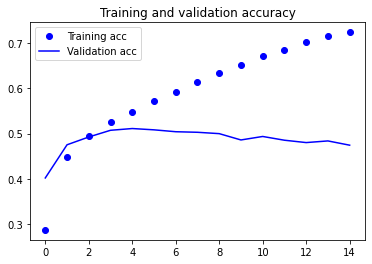

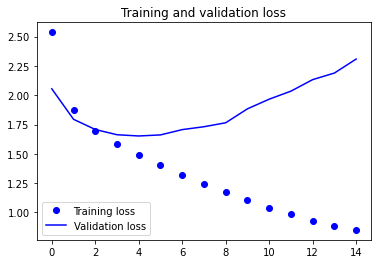

In [ ]:
# +1 Dense layer

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=128, input_shape=(maxlen, len(chars)), kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

Epoch 1/100
453/453 [==============================] - 7s 13ms/step - loss: 2.2464 - acc: 0.3608 - val_loss: 1.8349 - val_acc: 0.4580
Epoch 2/100
453/453 [==============================] - 6s 13ms/step - loss: 1.7022 - acc: 0.4886 - val_loss: 1.6813 - val_acc: 0.4953
Epoch 3/100
453/453 [==============================] - 6s 12ms/step - loss: 1.5078 - acc: 0.5360 - val_loss: 1.6543 - val_acc: 0.5058
Epoch 4/100
453/453 [==============================] - 6s 13ms/step - loss: 1.3453 - acc: 0.5784 - val_loss: 1.6586 - val_acc: 0.5069
Epoch 5/100
453/453 [==============================] - 6s 12ms/step - loss: 1.1773 - acc: 0.6250 - val_loss: 1.8005 - val_acc: 0.4950
Epoch 6/100
453/453 [==============================] - 6s 12ms/step - loss: 1.0141 - acc: 0.6720 - val_loss: 1.9149 - val_acc: 0.4839
Epoch 7/100
453/453 [==============================] - 6s 12ms/step - loss: 0.8629 - acc: 0.7175 - val_loss: 2.1171 - val_acc: 0.4735
Epoch 8/100
453/453 [==============================] - 6s 12ms

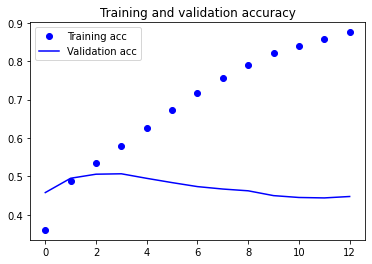

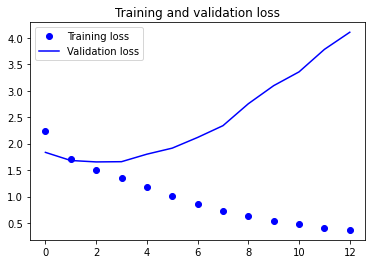

In [ ]:
# Dense 128 Nodes

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=128, input_shape=(maxlen, len(chars)), kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

Epoch 1/100
453/453 [==============================] - 7s 13ms/step - loss: 2.4297 - acc: 0.3128 - val_loss: 1.9728 - val_acc: 0.4320
Epoch 2/100
453/453 [==============================] - 6s 12ms/step - loss: 1.8423 - acc: 0.4590 - val_loss: 1.7892 - val_acc: 0.4744
Epoch 3/100
453/453 [==============================] - 5s 12ms/step - loss: 1.6804 - acc: 0.4986 - val_loss: 1.7067 - val_acc: 0.4965
Epoch 4/100
453/453 [==============================] - 5s 12ms/step - loss: 1.5813 - acc: 0.5227 - val_loss: 1.6945 - val_acc: 0.5001
Epoch 5/100
453/453 [==============================] - 6s 12ms/step - loss: 1.4963 - acc: 0.5441 - val_loss: 1.7099 - val_acc: 0.4998
Epoch 6/100
453/453 [==============================] - 6s 12ms/step - loss: 1.4304 - acc: 0.5614 - val_loss: 1.7235 - val_acc: 0.5017
Epoch 7/100
453/453 [==============================] - 5s 12ms/step - loss: 1.3750 - acc: 0.5766 - val_loss: 1.7172 - val_acc: 0.5022
Epoch 8/100
453/453 [==============================] - 5s 12ms

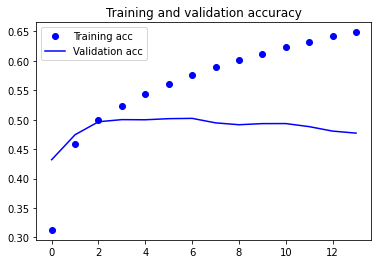

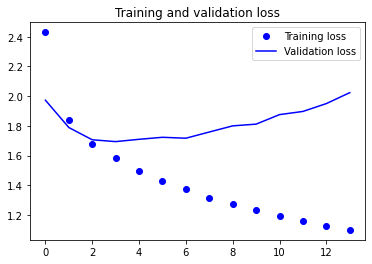

In [ ]:
# learning rate = 0.005

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=128, input_shape=(maxlen, len(chars)), kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

Epoch 1/100
453/453 [==============================] - 6s 13ms/step - loss: 2.4181 - acc: 0.3267 - val_loss: 2.0462 - val_acc: 0.4095
Epoch 2/100
453/453 [==============================] - 6s 12ms/step - loss: 1.8936 - acc: 0.4483 - val_loss: 1.8300 - val_acc: 0.4693
Epoch 3/100
453/453 [==============================] - 6s 12ms/step - loss: 1.7144 - acc: 0.4913 - val_loss: 1.7722 - val_acc: 0.4832
Epoch 4/100
453/453 [==============================] - 6s 12ms/step - loss: 1.5894 - acc: 0.5220 - val_loss: 1.7195 - val_acc: 0.4898
Epoch 5/100
453/453 [==============================] - 6s 12ms/step - loss: 1.4801 - acc: 0.5510 - val_loss: 1.7241 - val_acc: 0.4935
Epoch 6/100
453/453 [==============================] - 6s 12ms/step - loss: 1.3823 - acc: 0.5777 - val_loss: 1.6953 - val_acc: 0.5023
Epoch 7/100
453/453 [==============================] - 6s 13ms/step - loss: 1.2889 - acc: 0.6033 - val_loss: 1.7598 - val_acc: 0.4930
Epoch 8/100
453/453 [==============================] - 6s 12ms

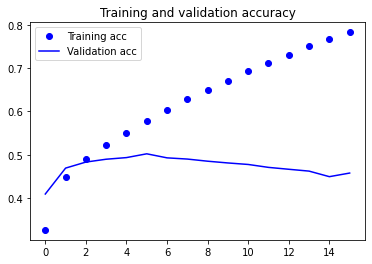

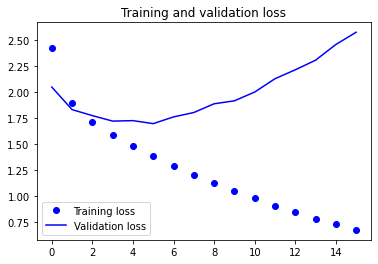

In [ ]:
# lr = 0.001

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=128, input_shape=(maxlen, len(chars)), kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

Epoch 1/100
453/453 [==============================] - 9s 18ms/step - loss: 2.6896 - acc: 0.2518 - val_loss: 2.1070 - val_acc: 0.3875
Epoch 2/100
453/453 [==============================] - 6s 14ms/step - loss: 1.8747 - acc: 0.4538 - val_loss: 1.7637 - val_acc: 0.4834
Epoch 3/100
453/453 [==============================] - 7s 14ms/step - loss: 1.6547 - acc: 0.5102 - val_loss: 1.6778 - val_acc: 0.5091
Epoch 4/100
453/453 [==============================] - 7s 14ms/step - loss: 1.5303 - acc: 0.5426 - val_loss: 1.6156 - val_acc: 0.5251
Epoch 5/100
453/453 [==============================] - 6s 14ms/step - loss: 1.4278 - acc: 0.5663 - val_loss: 1.6065 - val_acc: 0.5241
Epoch 6/100
453/453 [==============================] - 6s 14ms/step - loss: 1.3358 - acc: 0.5902 - val_loss: 1.6310 - val_acc: 0.5258
Epoch 7/100
453/453 [==============================] - 6s 14ms/step - loss: 1.2414 - acc: 0.6147 - val_loss: 1.6819 - val_acc: 0.5211
Epoch 8/100
453/453 [==============================] - 6s 14ms

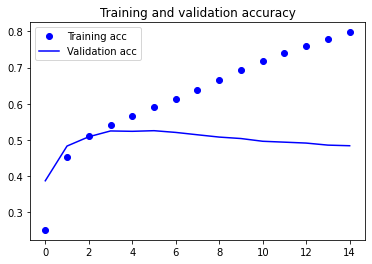

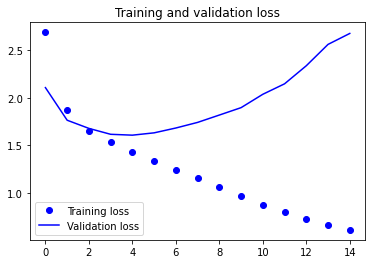

In [ ]:
# kernel Size = 5

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=128, input_shape=(maxlen, len(chars)), kernel_size=5, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

Epoch 1/100
453/453 [==============================] - 9s 19ms/step - loss: 2.4591 - acc: 0.3086 - val_loss: 1.9531 - val_acc: 0.4339
Epoch 2/100
453/453 [==============================] - 7s 15ms/step - loss: 1.7635 - acc: 0.4820 - val_loss: 1.7181 - val_acc: 0.4972
Epoch 3/100
453/453 [==============================] - 7s 15ms/step - loss: 1.5660 - acc: 0.5316 - val_loss: 1.6255 - val_acc: 0.5195
Epoch 4/100
453/453 [==============================] - 8s 17ms/step - loss: 1.4431 - acc: 0.5637 - val_loss: 1.5976 - val_acc: 0.5307
Epoch 5/100
453/453 [==============================] - 7s 15ms/step - loss: 1.3376 - acc: 0.5915 - val_loss: 1.6310 - val_acc: 0.5234
Epoch 6/100
453/453 [==============================] - 7s 15ms/step - loss: 1.2423 - acc: 0.6158 - val_loss: 1.6634 - val_acc: 0.5266
Epoch 7/100
453/453 [==============================] - 7s 15ms/step - loss: 1.1438 - acc: 0.6435 - val_loss: 1.7692 - val_acc: 0.5156
Epoch 8/100
453/453 [==============================] - 7s 16ms

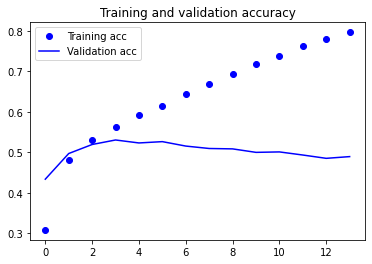

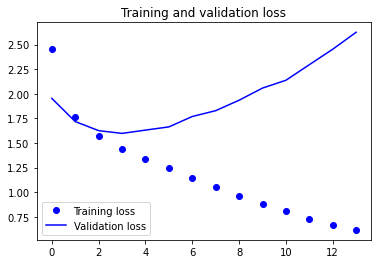

In [ ]:
# kernel size = 7 (selected)

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=128, input_shape=(maxlen, len(chars)), kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

Epoch 1/100
453/453 [==============================] - 14s 23ms/step - loss: 2.3193 - acc: 0.3445 - val_loss: 2.2895 - val_acc: 0.3539
Epoch 2/100
453/453 [==============================] - 10s 22ms/step - loss: 1.7661 - acc: 0.4724 - val_loss: 1.7434 - val_acc: 0.4841
Epoch 3/100
453/453 [==============================] - 10s 21ms/step - loss: 1.5649 - acc: 0.5243 - val_loss: 1.6841 - val_acc: 0.5014
Epoch 4/100
453/453 [==============================] - 10s 21ms/step - loss: 1.4234 - acc: 0.5604 - val_loss: 1.6769 - val_acc: 0.5082
Epoch 5/100
453/453 [==============================] - 9s 21ms/step - loss: 1.2926 - acc: 0.5952 - val_loss: 1.7584 - val_acc: 0.5037
Epoch 6/100
453/453 [==============================] - 10s 22ms/step - loss: 1.1695 - acc: 0.6307 - val_loss: 1.7834 - val_acc: 0.5025
Epoch 7/100
453/453 [==============================] - 10s 22ms/step - loss: 1.0506 - acc: 0.6649 - val_loss: 1.9272 - val_acc: 0.4875
Epoch 8/100
453/453 [==============================] - 9

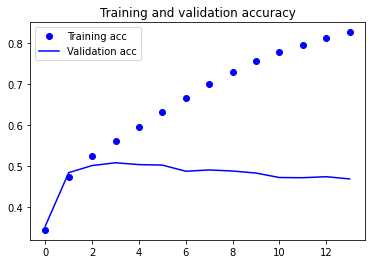

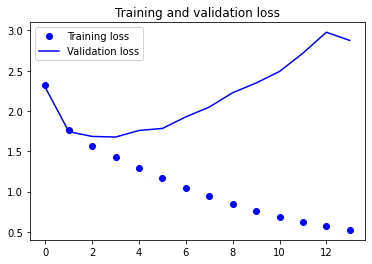

In [ ]:
# Batch Normalization

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=128, input_shape=(maxlen, len(chars)), kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

Epoch 1/100
453/453 [==============================] - 9s 17ms/step - loss: 2.8499 - acc: 0.2123 - val_loss: 2.3871 - val_acc: 0.3059
Epoch 2/100
453/453 [==============================] - 8s 17ms/step - loss: 2.3304 - acc: 0.3225 - val_loss: 2.0935 - val_acc: 0.3897
Epoch 3/100
453/453 [==============================] - 8s 17ms/step - loss: 2.1704 - acc: 0.3655 - val_loss: 1.9772 - val_acc: 0.4185
Epoch 4/100
453/453 [==============================] - 8s 19ms/step - loss: 2.0913 - acc: 0.3875 - val_loss: 1.8940 - val_acc: 0.4460
Epoch 5/100
453/453 [==============================] - 8s 19ms/step - loss: 2.0303 - acc: 0.4050 - val_loss: 1.8456 - val_acc: 0.4503
Epoch 6/100
453/453 [==============================] - 8s 17ms/step - loss: 1.9854 - acc: 0.4185 - val_loss: 1.8218 - val_acc: 0.4640
Epoch 7/100
453/453 [==============================] - 8s 17ms/step - loss: 1.9487 - acc: 0.4272 - val_loss: 1.7833 - val_acc: 0.4741
Epoch 8/100
453/453 [==============================] - 8s 17ms

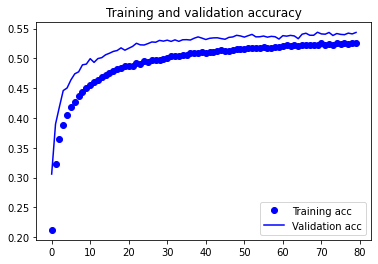

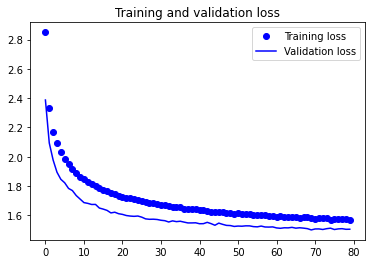

In [ ]:
# Dropout 0.3

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=128, input_shape=(maxlen, len(chars)), kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

Epoch 1/100
453/453 [==============================] - 9s 19ms/step - loss: 2.8653 - acc: 0.2100 - val_loss: 2.3775 - val_acc: 0.3087
Epoch 2/100
453/453 [==============================] - 8s 18ms/step - loss: 2.2571 - acc: 0.3458 - val_loss: 2.0058 - val_acc: 0.4165
Epoch 3/100
453/453 [==============================] - 8s 17ms/step - loss: 2.0417 - acc: 0.4078 - val_loss: 1.8528 - val_acc: 0.4542
Epoch 4/100
453/453 [==============================] - 8s 17ms/step - loss: 1.9340 - acc: 0.4368 - val_loss: 1.7890 - val_acc: 0.4753
Epoch 5/100
453/453 [==============================] - 8s 17ms/step - loss: 1.8692 - acc: 0.4537 - val_loss: 1.7436 - val_acc: 0.4916
Epoch 6/100
453/453 [==============================] - 8s 17ms/step - loss: 1.8187 - acc: 0.4653 - val_loss: 1.7071 - val_acc: 0.5003
Epoch 7/100
453/453 [==============================] - 8s 17ms/step - loss: 1.7841 - acc: 0.4741 - val_loss: 1.6694 - val_acc: 0.5051
Epoch 8/100
453/453 [==============================] - 8s 17ms

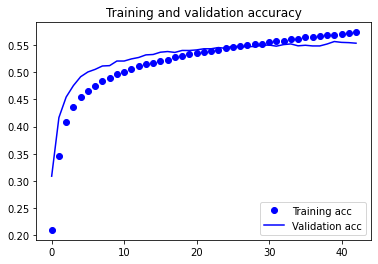

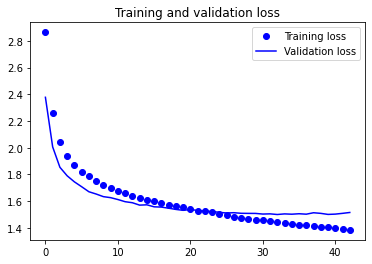

--- Generating with seed: "t had happened. it was enough. up in the air, harry was sudd"
------ temperature: 0.2
t had happened. it was enough. up in the air, harry was suddenly 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


a mind the corner and the way and the was should a large stayed to the stor and the stors had a stouted to she something and show the short and shook the stor doors of the story thought had a books had a still her some to the corner a chastic and the stor a sound a books seemed to be was so harry was the doors of the doors of his stand a books and stort and stored his hand a shouted harry was
Rogue_Score
0.4451219512195122

------ temperature: 0.5
t had happened. it was enough. up in the air, harry was suddenly and some to better for the thought and made at seem the table the dropped like the swas the got a cream harry than he couldn’t blink who tried and did the reached the library and harry was when he’d the whispered a met harry was a show out the tot to shart to read from yefless a bit the later shouted out of the nocked on his aunt petunia. he looked and done into the house door in scan him and
Rogue_Score
0.6158536585365854

------ temperature: 1.0
t had happened. it was enough. 

In [17]:
# Dropout 0.2 (Selected) (reran)

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=128, input_shape=(maxlen, len(chars)), kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

gen_text(model)

Epoch 1/100
453/453 [==============================] - 8s 17ms/step - loss: 2.6592 - acc: 0.2574 - val_loss: 2.1497 - val_acc: 0.3746
Epoch 2/100
453/453 [==============================] - 8s 17ms/step - loss: 2.0572 - acc: 0.4041 - val_loss: 1.8747 - val_acc: 0.4518
Epoch 3/100
453/453 [==============================] - 8s 17ms/step - loss: 1.8791 - acc: 0.4511 - val_loss: 1.7856 - val_acc: 0.4797
Epoch 4/100
453/453 [==============================] - 8s 17ms/step - loss: 1.7812 - acc: 0.4741 - val_loss: 1.7094 - val_acc: 0.4953
Epoch 5/100
453/453 [==============================] - 8s 17ms/step - loss: 1.7070 - acc: 0.4923 - val_loss: 1.6583 - val_acc: 0.5052
Epoch 6/100
453/453 [==============================] - 8s 17ms/step - loss: 1.6508 - acc: 0.5058 - val_loss: 1.6216 - val_acc: 0.5196
Epoch 7/100
453/453 [==============================] - 8s 17ms/step - loss: 1.6048 - acc: 0.5177 - val_loss: 1.6077 - val_acc: 0.5198
Epoch 8/100
453/453 [==============================] - 7s 17ms

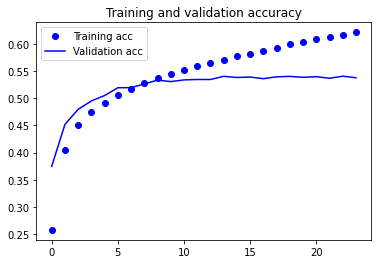

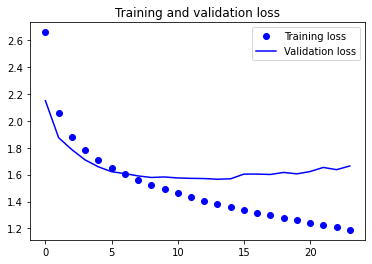

In [18]:
# Dropout 0.1 

model = Sequential()
model.add(tf.keras.layers.Conv1D(filters=128, input_shape=(maxlen, len(chars)), kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=7, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool1D(pool_size=1))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

graphs(history)

In [29]:
# BEST MODEL OVERALL

model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.1, return_sequences=True), input_shape=(maxlen, len(chars))))
model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.1)))
model.add(Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(len(chars), activation='softmax'))

history = compile_fit(
    model=model,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['acc'],
    callback=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15),
    batch_size=256,
    epochs=100,
    X=X,
    y=y,
)

model.save('best_model_Problem2.h5')

Epoch 1/100
453/453 [==============================] - 24s 41ms/step - loss: 2.3100 - acc: 0.3315 - val_loss: 1.8467 - val_acc: 0.4538
Epoch 2/100
453/453 [==============================] - 18s 39ms/step - loss: 1.8029 - acc: 0.4568 - val_loss: 1.6350 - val_acc: 0.5049
Epoch 3/100
453/453 [==============================] - 18s 39ms/step - loss: 1.6470 - acc: 0.4971 - val_loss: 1.5537 - val_acc: 0.5216
Epoch 4/100
453/453 [==============================] - 19s 41ms/step - loss: 1.5625 - acc: 0.5196 - val_loss: 1.5040 - val_acc: 0.5407
Epoch 5/100
453/453 [==============================] - 21s 45ms/step - loss: 1.5060 - acc: 0.5346 - val_loss: 1.4797 - val_acc: 0.5449
Epoch 6/100
453/453 [==============================] - 17s 38ms/step - loss: 1.4646 - acc: 0.5449 - val_loss: 1.4589 - val_acc: 0.5554
Epoch 7/100
453/453 [==============================] - 18s 39ms/step - loss: 1.4338 - acc: 0.5522 - val_loss: 1.4367 - val_acc: 0.5606
Epoch 8/100
453/453 [==============================] - 

## Step 3 – Use the developed Model to generate the characters / sentences

In [12]:
# Loading the model
import warnings
warnings.filterwarnings("ignore")

model = tf.keras.models.load_model("best_model_Problem2.h5")

In [30]:
# takes the user input
print("Please enter an input")
text_input = input()
text_input = text_input.lower()

holder = ""
for char in text_input:
  if char in chars:
    holder += char

text_input = holder

if len(text_input) > 60:
  print("Using only first 60 characters of input!")
  text_input = text_input[:60]

while len(text_input) < 60:
  text_input = " " + text_input
print(text_input)
print(len(text_input))

Please enter an input
                          wow that ice cream was really deli
60


In [ ]:
for temperature in [0.5]:
    generated_text = text_input
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.
        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

In [37]:
# Putting the code all into a function
def prediction():
  text_input = input()
  text_input = text_input.lower()

  holder = ""
  for char in text_input:
    if char in chars:
      holder += char

  text_input = holder

  if len(text_input) > 60:
    print("Using only first 60 characters of input!")
    text_input = text_input[:60]

  while len(text_input) < 60:
    text_input = " " + text_input
  for temperature in [0.5]:
    generated_text = text_input
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.
        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()
    return

In [38]:
# The spaghetti was absolutely delicious I never at something so good!
# Truncated to the spaghetti was absolutely delicious i never at
prediction()

Using only first 60 characters of input!
------ temperature: 0.5
the spaghetti was absolutely delicious i never at something at hogwarts, who couldn’t be coming somethin’ he’d lost the neilden and he could they went to get of the gryffindors and peeves had to be possible had the same that he was going to neville darkness and get the gryffindors “what’s you, we shake professor mcgonagall turned out a beat again. harry could have been before the common again, which could they were another ready and floped again. the landi


In [41]:
# !~?:; those what are symbols doing <_>
prediction()

------ temperature: 0.5
                            !? those what are symbols doing they were a large flamel and much the common the first time the broomstick the great later seemed the collopsing around the castle balls and when they was strange and started to get a talk and it the boats of the twins pace the end of his fick charmed and had getting harry’s face were ready when they had no taken anything they could be them what they speed as the cat saw a dudley didn’t heard him 


In [40]:
# just carry on with you homew
prediction()

------ temperature: 0.5
                                just carry on with you homewor the gryffindors every common looks at the boy which was faster after the window. “be the ruffled from dark and he couldn’t be a bit of them arrived the stone of hagrid before, and he was grunting not a lot of his broom the storm in a first team with the train the gryffindor the charm the small. he couldn’t be and he was the dear and they were at him and everything and dudley was a better again.


In [36]:
# encode the user input
#encoded_text_input = np.zeros((1, maxlen, len(chars)), dtype=bool) # 3D?/2D? array of 1 X length text input X 47image.png
#for word in range(0, len(text_input)):
 # index = word
  #real_word = text_input[index]
  #encoded_text_input[index, char_indices[real_word]] = 1